<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/min_vertex_cover_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
#!pip install pennylane
#!pip install qulacs pennylane-qulacs
#!pip install seaborn
#!pip install lightning
#!pip install ipynbname

In [2]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml
#from pennylane.utils import _flatten, unflatten
from pennylane import GradientDescentOptimizer
import copy
#from momentum_qng import MomentumQNGOptimizer

In [3]:
def get_cover_set(val,N):
    cover = set()
    for i in range(N):
        if((val%2) == 1):
            cover.add(N-1-i)
        val >>= 1
    return cover
            
def find_minimal_covers(node_count,G):
    min_cover_rank = node_count
    min_covers = []
    min_covers_id = []
    for k in range(1<<node_count):
        cover = get_cover_set(k,node_count)
        is_cover = True
        for u, v in G.edges():
            if u in cover or v in cover:
                continue
            else:
                is_cover = False
                break
        if(is_cover):
            rank = len(cover)
            #print(rank)
            if(rank < min_cover_rank):
                min_cover_rank = rank
                min_covers.clear()
                min_covers.append(cover)
                min_covers_id.clear()
                min_covers_id.append(k)                
            else:
                if( rank == min_cover_rank):
                    min_covers.append(cover)
                    min_covers_id.append(k)
            
    return min_covers, min_covers_id

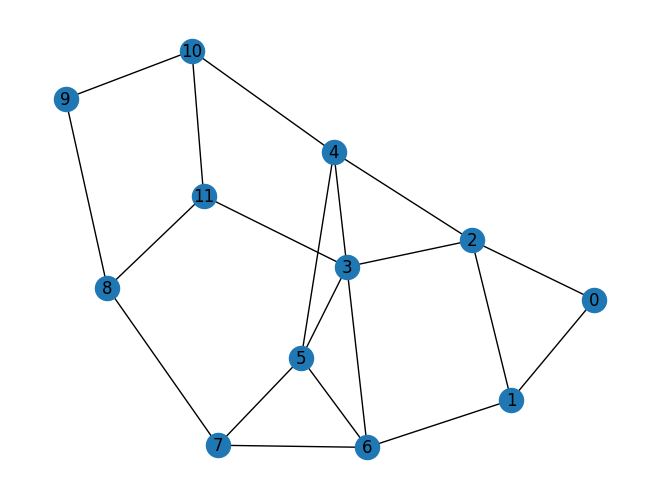

[{1, 2, 3, 5, 7, 8, 10}, {1, 2, 3, 5, 6, 8, 10}, {0, 2, 3, 5, 6, 8, 10}]
[1882, 1898, 2922]


In [4]:
edges = [(0, 1), (2, 0), (1, 2), (3, 2), (3, 4), (2, 4), (3, 6), (3, 5), (5, 6), (3, 11), (4, 5),
        (1, 6), (6, 7), (5, 7), (4, 10), (10, 11), (8, 11), (8, 7), (8, 9), (10, 9)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

min_covers,min_covers_id = find_minimal_covers(12,graph)
print(min_covers)
print(min_covers_id)

In [5]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(6)) + 0.75 * Z(1) + 0.75 * Z(6) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + 0.75 * (Z(2) @ Z(4)) + 0.75 * Z(2) + 0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + 0.75 * Z(3) + 0.75 * Z(4) + 0.75 * (Z(3) @ Z(6)) + 0.75 * Z(3) + 0.75 * Z(6) + 0.75 * (Z(3) @ Z(5)) + 0.75 * Z(3) + 0.75 * Z(5) + 0.75 * (Z(3) @ Z(11)) + 0.75 * Z(3) + 0.75 * Z(11) + 0.75 * (Z(4) @ Z(5)) + 0.75 * Z(4) + 0.75 * Z(5) + 0.75 * (Z(4) @ Z(10)) + 0.75 * Z(4) + 0.75 * Z(10) + 0.75 * (Z(6) @ Z(5)) + 0.75 * Z(6) + 0.75 * Z(5) + 0.75 * (Z(6) @ Z(7)) + 0.75 * Z(6) + 0.75 * Z(7) + 0.75 * (Z(5) @ Z(7)) + 0.75 * Z(5) + 0.75 * Z(7) + 0.75 * (Z(11) @ Z(10)) + 0.75 * Z(11) + 0.75 * Z(10) + 0.75 * (Z(11) @ Z(8)) + 0.75 * Z(11) + 0.75 * Z(8) + 0.75 * (Z(7) @ Z(8)) + 0.75 * Z(7) + 0.75 * Z(8) + 0.75 * (Z(10) @ Z(9)) + 0.75 * Z(10) + 0.75 * Z(9) + 0.

In [6]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [7]:
N = 12 #number of nodes/qubits
wires = range(N)
depth = 4

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [8]:
def plot_opt_data(opt_costs,opt_quality,opt_steps,opt_title,opt_color):
    fig = plt.figure(figsize=(12, 3), layout="compressed")
    axs = fig.subplots(1, 4, sharey=False)
    #fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=False)

    # We can set the number of bins with the *bins* keyword argument.
    n_bins = 10
    quality_bins = [i*0.02 for i in range(50)]
    cost_bins = [-3+i*0.04 for i in range(75)]
    steps_bins = [i for i in range(steps+1)]
    axs[0].hist(opt_costs, bins=cost_bins,color=opt_color)
    axs[1].hist(opt_quality, bins=quality_bins,color=opt_color)
    axs[2].scatter(opt_costs,opt_quality,color=opt_color)
    axs[3].hist(opt_steps, bins=steps_bins,color=opt_color)
    axs[0].set_xlabel("optimized cost")
    axs[0].set_ylabel("count")
    axs[1].set_xlabel("quality ratio")
    axs[1].set_ylabel("count")
    #axs[0].set_title(opt_title)
    #axs[1].set_title(opt_title)
    axs[2].set_xlabel("optimized cost")
    axs[2].set_ylabel("quality ratio")
    axs[2].set_xlim(-3,0)
    axs[2].set_ylim(0,1)
    axs[3].set_xlabel("steps")
    axs[3].set_ylabel("count")
    plt.suptitle(opt_title)
    plt.show()

In [9]:
def run_session(optimizer,optimizer_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,device_name):
    dev = qml.device(device_name, wires=wires)
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)
    def quality_ratio(params):
        probs = probability_circuit(params[0], params[1])
        return probs[1882]+probs[1898]+probs[2922]

    def asymmetry_ratio1(params):
        probs = probability_circuit(params[0], params[1])
        return probs[1882]/probs[2922]
    def asymmetry_ratio2(params):
        probs = probability_circuit(params[0], params[1])
        return probs[1898]/probs[2922]
        
    opt_params = []
    opt_steps = []
    opt_costs = []
    opt_quality = []
    opt_asym1 = []
    opt_asym2 = []
    for init_params in tqdm(init_params_array):
        opt = copy.deepcopy(optimizer)
        for id in optimizer_params:
            setattr(opt, id, optimizer_params[id])
        params = init_params
        best_cost = 100
        cost_counter = 0
        for i in range(steps):
            params = opt.step(cost_function, params)
            cur_cost = cost_function(params)
            if(abs(best_cost - cur_cost) < cost_tolerance):
                cost_counter += 1
                if(cost_counter > cost_tolerance_count):
                    break
            else:
                cost_counter = 0
            if(best_cost > cur_cost):
                best_cost = cur_cost
        opt_params.append(params)
        opt_steps.append(i)
        opt_costs.append(cur_cost)
        opt_quality.append(quality_ratio(params))
        opt_asym1.append(asymmetry_ratio1(params))
        opt_asym2.append(asymmetry_ratio2(params))
    return (opt_params,opt_steps,opt_costs,opt_quality,opt_asym1,opt_asym2)

In [10]:
sessions = [
    {"optimizer" :  qml.AdamOptimizer(),
     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
     "stepsizes" : [0.15,0.175,0.2,0.225,0.25],
     "dev" : "default.qubit"}
]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mbrat\AppData\Local\Temp\ipykernel_48120\327916983.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
C:\Users\mbrat\AppData\Local\Temp\ipykernel_48120\327916983.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
C:\Users\mbrat\AppData\Local\Temp\ipykernel_48120\327916983.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^

In [11]:
init_count = 200
steps = 200

cost_tolerance = 0.01
cost_tolerance_count = 3

seed_value = 340197

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    gam = np.random.random(depth)
    alp = np.random.random(depth)
    init_params_array.append(np.array([gam, alp], requires_grad=True))

100%|██████████| 200/200 [1:08:26<00:00, 20.53s/it]


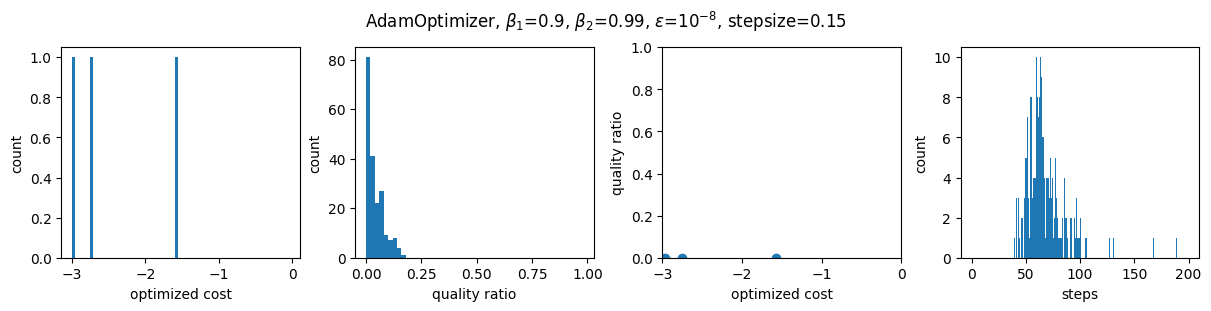

100%|██████████| 200/200 [1:08:47<00:00, 20.64s/it]


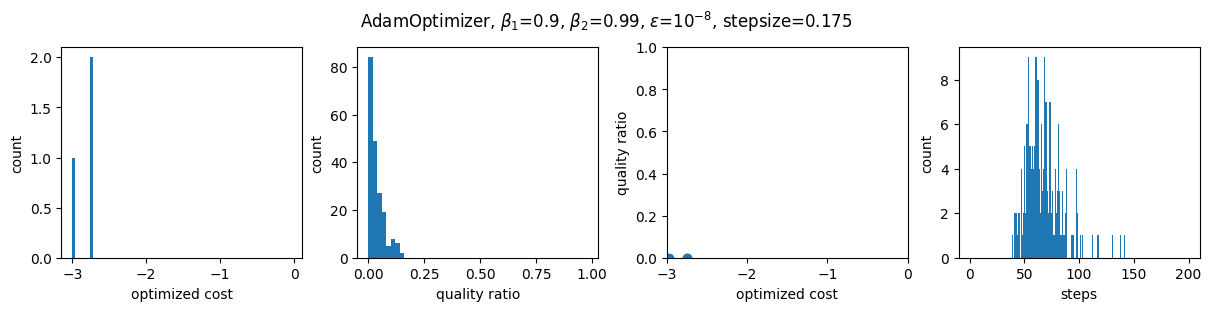

100%|██████████| 200/200 [1:11:30<00:00, 21.45s/it]


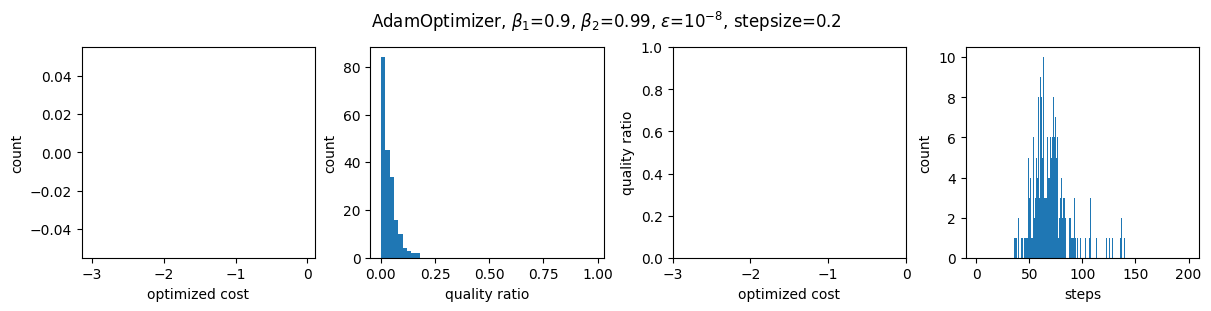

100%|██████████| 200/200 [1:18:54<00:00, 23.67s/it]


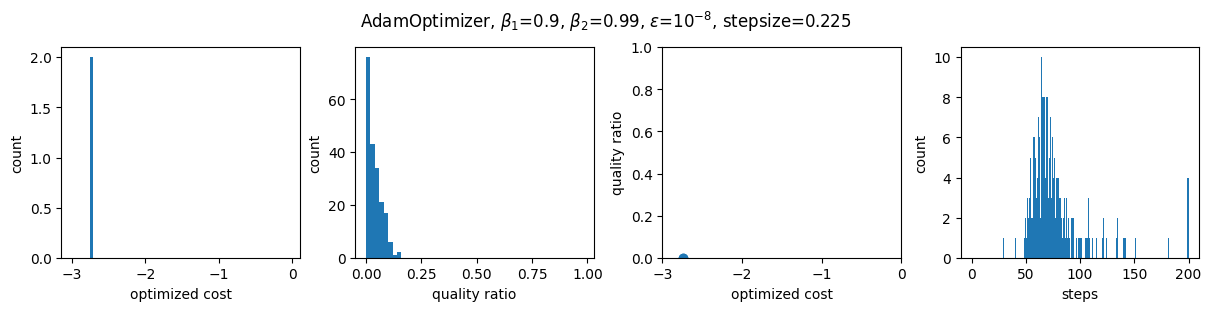

100%|██████████| 200/200 [1:17:06<00:00, 23.13s/it]


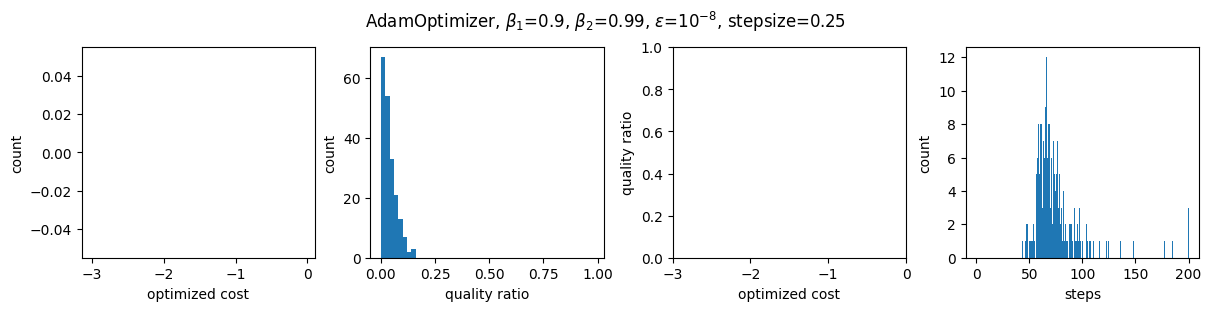

In [12]:
sessions_params = []
sessions_steps = []
sessions_costs = []
sessions_quality = []
sessions_asym1 = []
sessions_asym2 = []
for i,session in enumerate(sessions):
    cur_params = []
    cur_steps = []
    cur_costs = []
    cur_quality = []
    cur_asym1 = []
    cur_asym2 = []
    for stepsize in session["stepsizes"]:
        session_params = copy.deepcopy(session["params"])
        session_params["stepsize"] = stepsize
        (opt_params,opt_steps,opt_costs,opt_quality,opt_asym1,opt_asym2) = run_session(session["optimizer"],session_params,init_params_array,steps,cost_tolerance,cost_tolerance_count,session["dev"])
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", "+ session["params_name"]
        title += ", stepsize=" + str(stepsize)
        plot_opt_data(opt_costs,opt_quality,opt_steps,title,'C'+str(i))
        cur_params.append(opt_params)
        cur_steps.append(opt_steps)
        cur_costs.append(opt_costs)
        cur_quality.append(opt_quality)
        cur_asym1.append(opt_asym1)
        cur_asym2.append(opt_asym2)

    sessions_params.append(cur_params)
    sessions_steps.append(cur_steps)
    sessions_costs.append(cur_costs)
    sessions_quality.append(cur_quality)
    sessions_asym1.append(cur_asym1)
    sessions_asym2.append(cur_asym2)

In [13]:
from datetime import date
import ipynbname


start_name = ipynbname.name() + "_"
tail_name = "_depth=" + str(depth)+"_" + str(date.today()) + ".dat"
with open(start_name + "quality" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_quality[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "costs" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_costs[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "steps" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_steps[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "asym1" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_asym1[i][k][j]) + " "
        print(j,line,file=file)

with open(start_name + "asym2" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_asym2[i][k][j]) + " "
        print(j,line,file=file)
        
with open(start_name + "params" + tail_name, "w") as file:
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                line += str(sessions_params[i][k][j][0]) + " " + str(sessions_params[i][k][j][1]) + " "
        print(j,line,file=file)
